In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Control parameters

In [3]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [4]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [5]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [6]:
def get_species_indices(species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

In [7]:
bridge_indices = get_species_indices(BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

de = 0.2
energies = np.arange(-2., 2. + de / 2., de).round(7)
eta = 1e-3

## LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

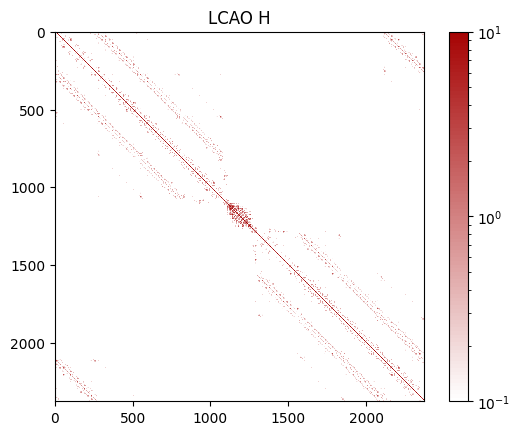

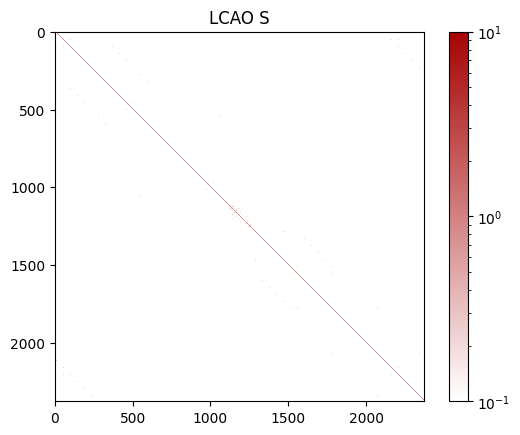

In [9]:
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO S")
plt.show()

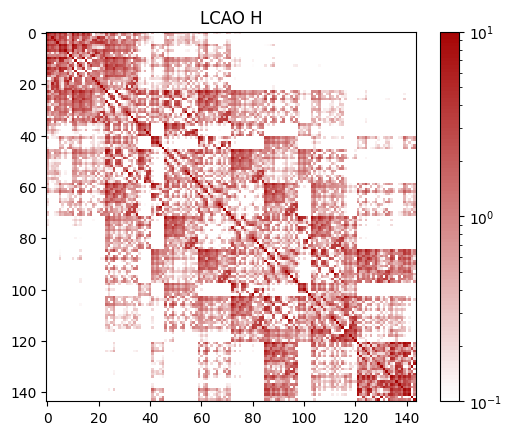

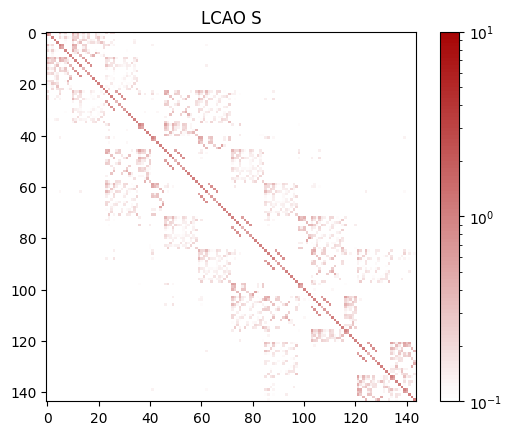

In [10]:
bridge_region_H_lcao = H_lcao[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_lcao = S_lcao[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO S")
plt.show()

### Subdiagonalize C, N and H of Hamiltonian and look at the effect on transmission function. 

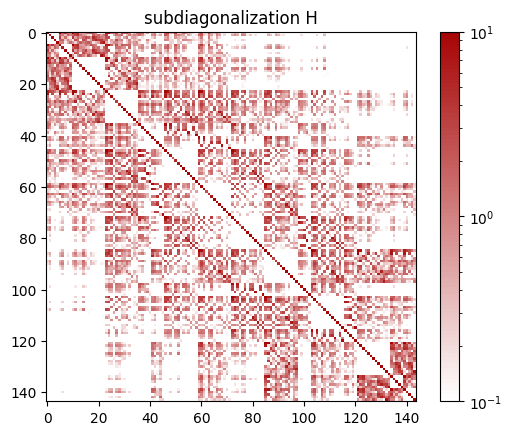

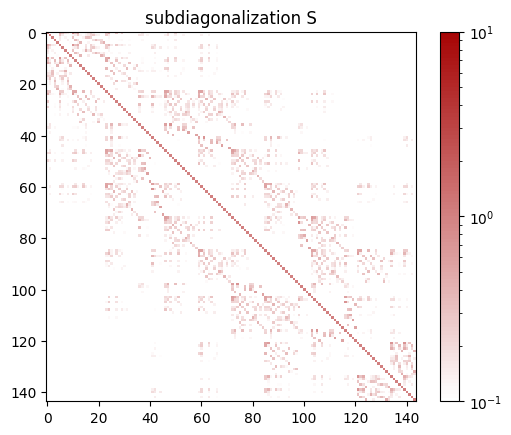

In [11]:
SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

bridge_region_H_sub = H_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

In [12]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0],
                                              len(leads_atoms.repeat(Nr)))

print(nodes)
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_sub_device[0], S_sub_device[0])


gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


[0, 810, 1116, 1260, 1566, 2376]


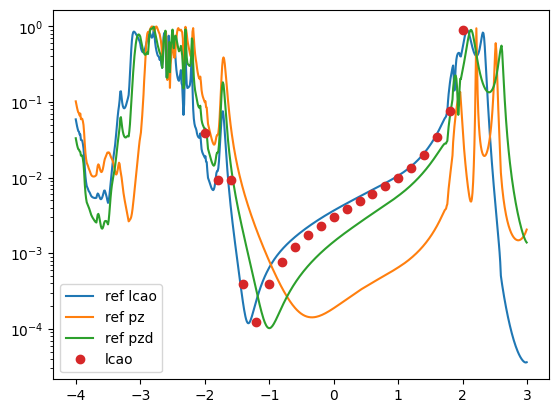

In [13]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="lcao")
plt.yscale("log")
plt.legend()

### Subdiagonalize C, N, H and Au tip of Hamiltonian and look at the effect on transmission function.

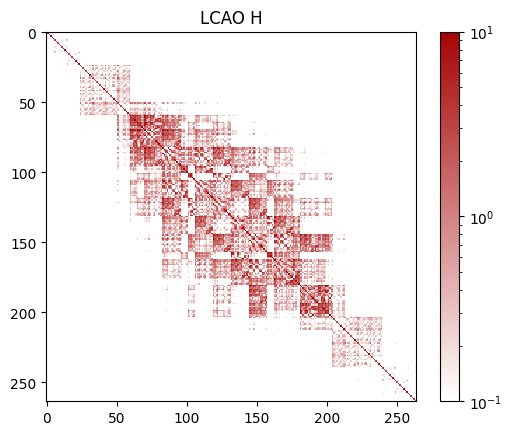

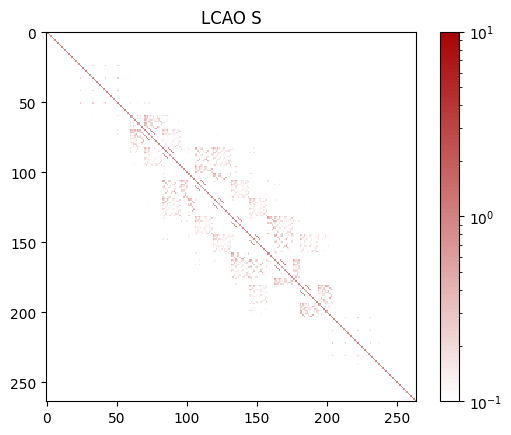

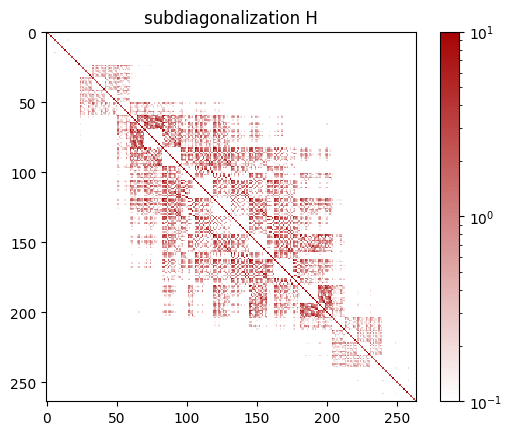

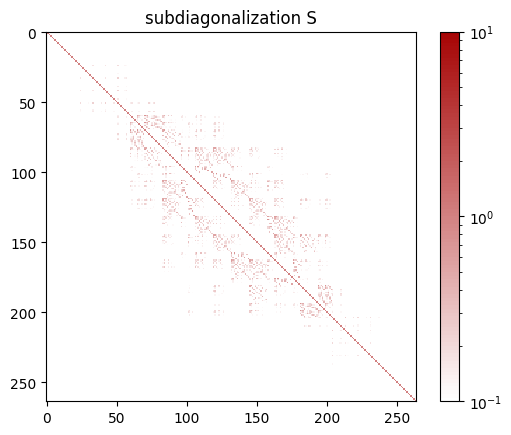

In [14]:
x = basis.atoms.positions[:, 0]
subdiag_indices =np.where((x > 7.2) & (x < 27))[0]

Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]


fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_lcao[bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(S_lcao[bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO S")
plt.show()


bridge_region_H_sub = H_sub_device[0,bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]
bridge_region_S_sub = S_sub_device[0,bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

In [15]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0],
                                              len(leads_atoms.repeat(Nr)))


hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_sub_device[0], S_sub_device[0])


gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T2 = np.empty(energies.size)

for e, energy in enumerate(energies):
    T2[e] = gf.get_transmission(energy)


In [16]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")
Tref_angelo = np.loadtxt("ET_Angelo.dat")

#plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
#plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
#plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(Tref_angelo[:,0],Tref_angelo[:,1],label="ref angelo")
plt.plot(energies,T,'o',label="lcao C N H")
plt.plot(energies,T2,'x',label="lcao C N H Au")
plt.yscale("log")
plt.legend()

OSError: ET_Angelo.dat not found.

### Subdiagonalize with 'a' parameter set to none, i.e the entire Hamiltonian is subdiagonalized

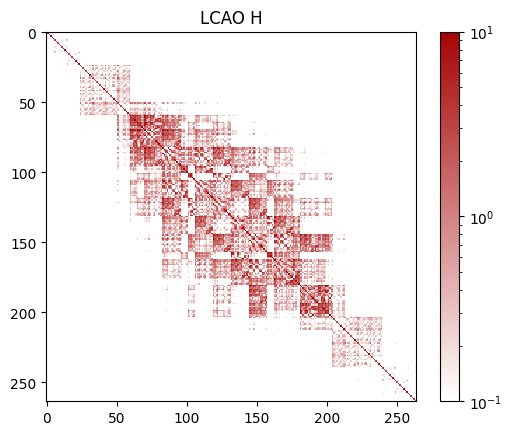

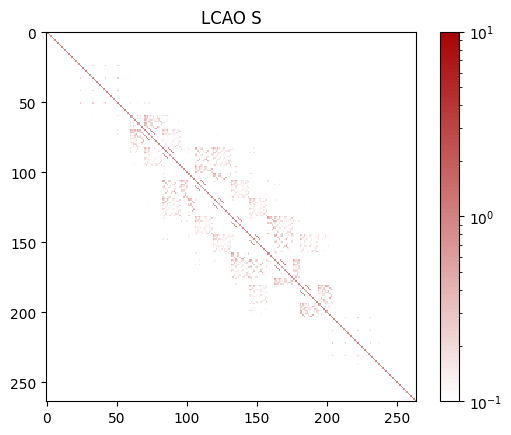

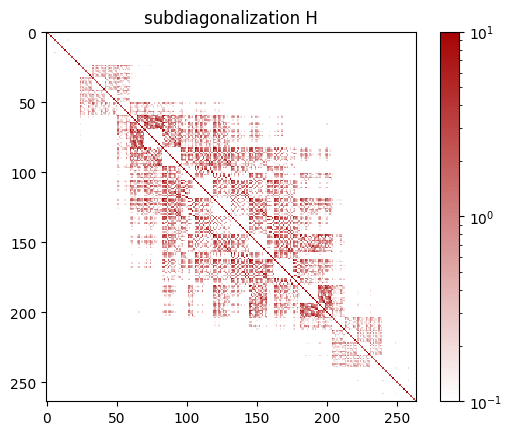

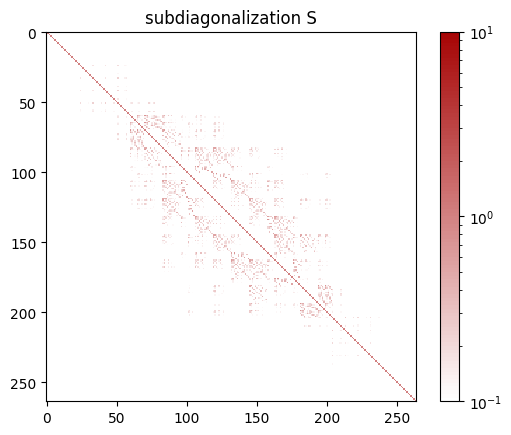

In [ ]:
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=None)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]


fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_lcao[bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(S_lcao[bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO S")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_sub_device[0,bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(S_sub_device[0,bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

In [ ]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0],
                                              len(leads_atoms.repeat(Nr)))


hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_sub_device[0], S_sub_device[0])


gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


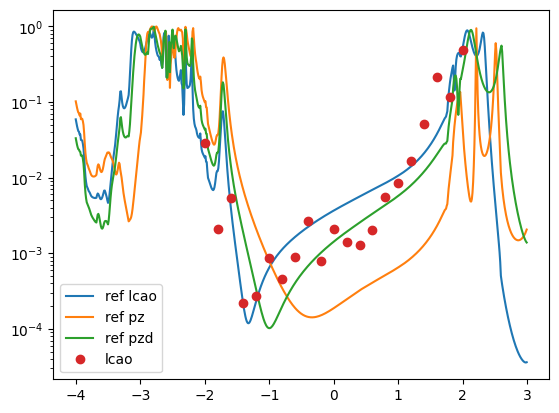

In [ ]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="lcao")
plt.yscale("log")
plt.legend()

### Subdiagonalize only C (Seems to be what the paper suggest to do) and look at T(E) 

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


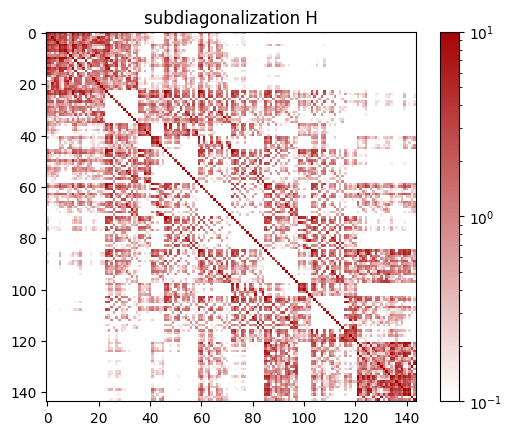

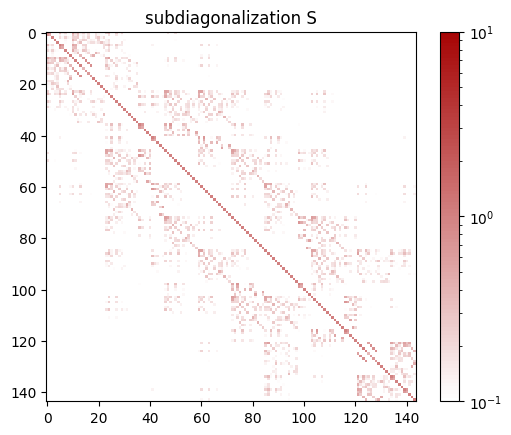

In [ ]:
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

print(np.dot(np.conj(Usub),Usub))

bridge_region_H_sub = H_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

[0, 810, 1116, 1219, 1260, 1566, 2376]


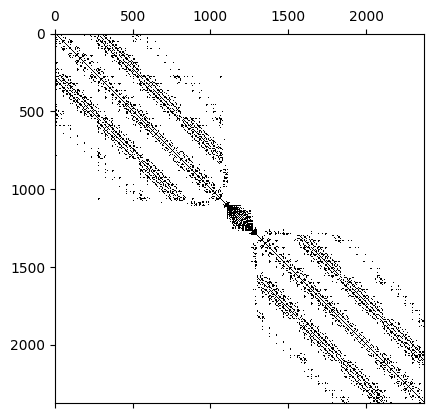

In [ ]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))
plt.spy(H_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1],precision=0.01)
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)
plt.spy(H_sub_device[0],precision=0.01)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0],
                                              len(leads_atoms.repeat(Nr)))
print(nodes)

hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_sub_device[0], S_sub_device[0])


gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


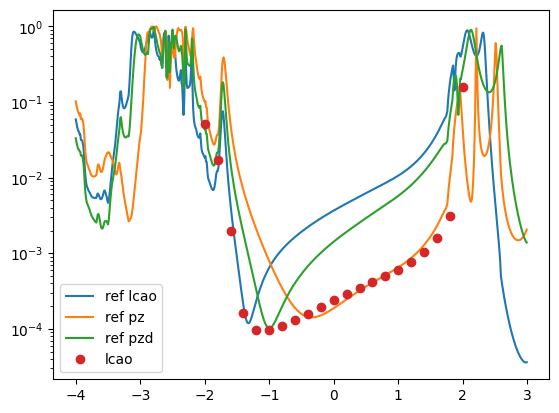

In [ ]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="lcao")
plt.yscale("log")
plt.legend()

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C 2pz are considered to be the active region 

In [ ]:
from copy import deepcopy

SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

active = {'C':3,'N':[0,1,2,3,4,5,6,7,8,9,10,11,12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]
print(index_active_region)
print(len(index_active_region))

active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)
print

cutcoupling(H_cutcoupled_device[0],S_cutcoupled_device[0], index_inactive_region)

bridge_region_H_cut = H_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled S")
plt.show()

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0,0,0]))
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

#nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_cutcoupled_device[0],
                                              #len(leads_atoms.repeat(Nr)))
nodes = [0, 810, 1116, 1260, 1566, 2376]
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_cutcoupled_device[0], S_cutcoupled_device[0])

print(nodes)
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)

ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="C 2 pz")
plt.yscale("log")
plt.legend()

[1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1142
 1165 1178 1191 1204 1222 1237 1238 1239 1240 1241 1242 1243 1244 1245
 1246 1247 1248 1249]
32


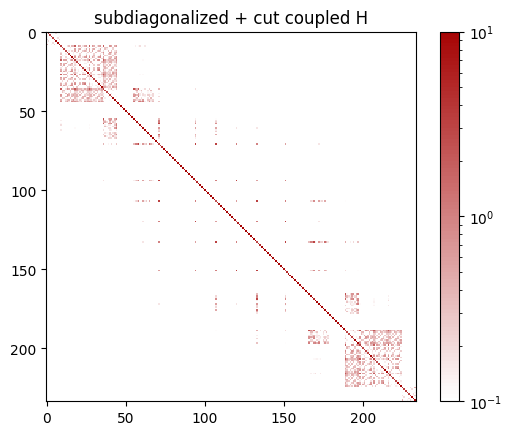

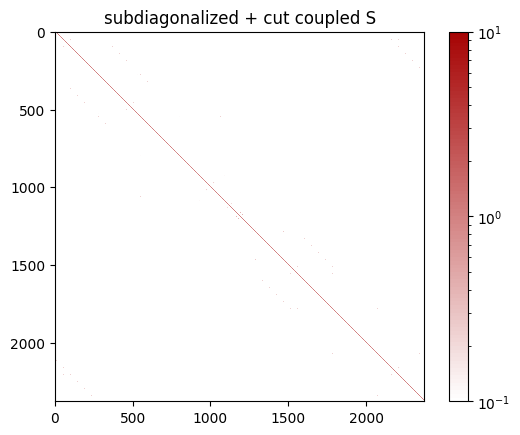

[0, 810, 1116, 1260, 1566, 2376]


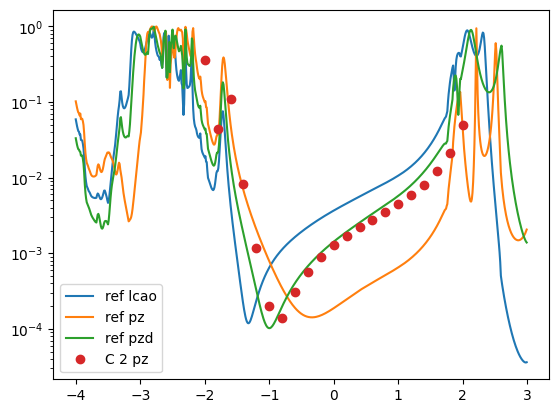

In [11]:
from copy import deepcopy

SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

active = {'C':3,'N':[0,1,2,3,4,5,6,7,8,9,10,11,12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]
print(index_active_region)
print(len(index_active_region))

active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

cutcoupling(H_cutcoupled_device[0],S_cutcoupled_device[0], index_inactive_region)

bridge_region_H_cut = H_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(H_cutcoupled_device[0,bridge_start-45:bridge_end+1+45,bridge_start-45:bridge_end+1+45]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(S_cutcoupled_device[0]), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled S")
plt.show()

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0,0,0]))
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

#nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_cutcoupled_device[0],
                                              #len(leads_atoms.repeat(Nr)))
nodes = [0, 810, 1116, 1260, 1566, 2376]
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_cutcoupled_device[0], S_cutcoupled_device[0])

print(nodes)
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)

ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="C 2 pz")
plt.yscale("log")
plt.legend()

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C 2pz and N 2pz are considered to be the active region 

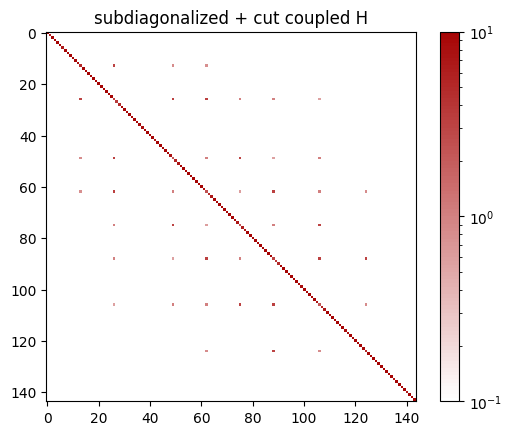

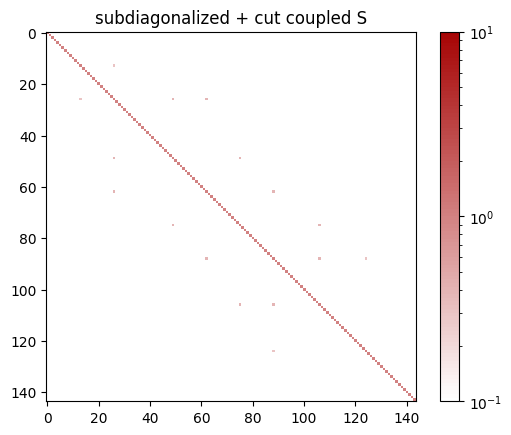

In [130]:
from copy import deepcopy

SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

active = {'C':3,'N':3}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

cutcoupling(H_cutcoupled_device[0],S_cutcoupled_device[0], index_inactive_region)

bridge_region_H_cut = H_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled S")
plt.show()


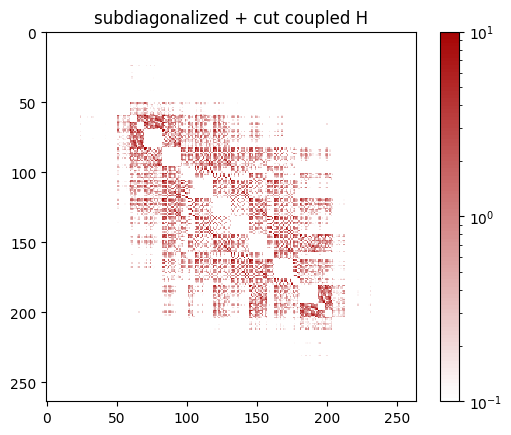

In [131]:
diff = abs(H_cutcoupled_device[0]-H_sub_device[0])
fig, ax = plt.subplots()
cax = ax.imshow(diff[bridge_start-60:bridge_end+61,bridge_start-60:bridge_end+61], interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled H")
plt.show()


In [132]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0,0,0]))
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

#nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_cutcoupled_device[0],
                                              #len(leads_atoms.repeat(Nr)))
nodes = [0, 810, 1116, 1260, 1566, 2376]
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_cutcoupled_device[0], S_cutcoupled_device[0])

print(nodes)
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


[0, 810, 1116, 1260, 1566, 2376]


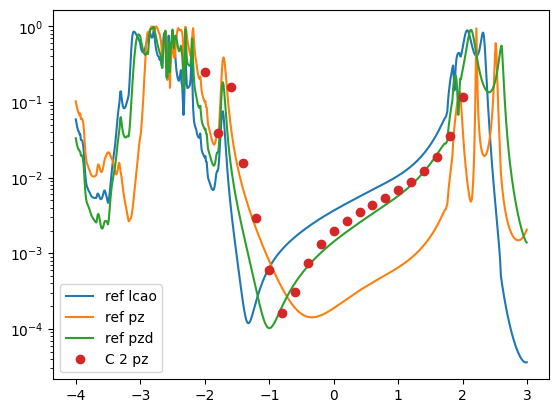

In [133]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="C 2 pz")
plt.yscale("log")
plt.legend()

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C pzd and N 2pz are considered to be the active region 

In [31]:
external_C_indices = [127, 133]
internal_C_indices = [130, 131, 132, 135]
kind = 'C'
active_ext_C = {kind: [3, 6, 7, 10, 12]}
active_int_C = {kind: [3, 6, 10, 12]}

search_result = atoms.symbols.search(kind)
M_a = np.cumsum(np.insert(nao_a[:-1], 0, 0))

idxlist = []

for a in search_result:
    if a in external_C_indices:
        idxlist.extend(M_a[a] + np.array(active_ext_C[kind]))
    elif a in internal_C_indices:
        idxlist.extend(M_a[a] + np.array(active_int_C[kind]))

idxlist = np.asarray(idxlist)

idxlist.sort()

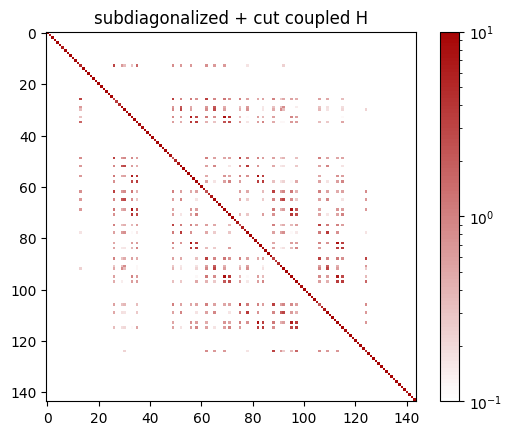

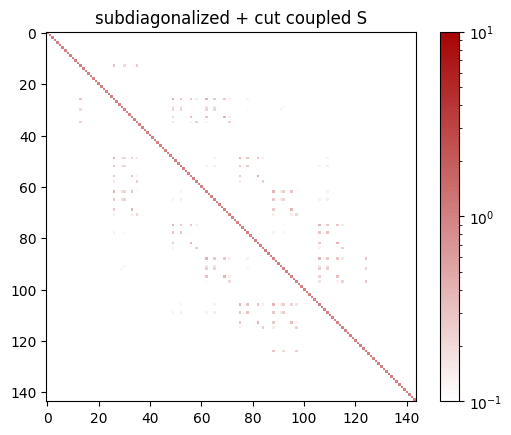

In [33]:
from copy import deepcopy

SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

active_N = {'N':3}
extract_active_region = basis_subdiag_region.extract().take(active_N)
index_active_region = index_subdiag_region[extract_active_region]
index_active_region = np.concatenate((idxlist,index_active_region))
index_active_region.sort()
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

cutcoupling(H_cutcoupled_device[0],S_cutcoupled_device[0], index_inactive_region)

bridge_region_H_cut = H_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalized + cut coupled S")
plt.show()


In [34]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0,0,0]))
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

#nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_cutcoupled_device[0],
                                              #len(leads_atoms.repeat(Nr)))
nodes = [0, 810, 1116, 1260, 1566, 2376]
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_cutcoupled_device[0], S_cutcoupled_device[0])

print(nodes)
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


[0, 810, 1116, 1260, 1566, 2376]


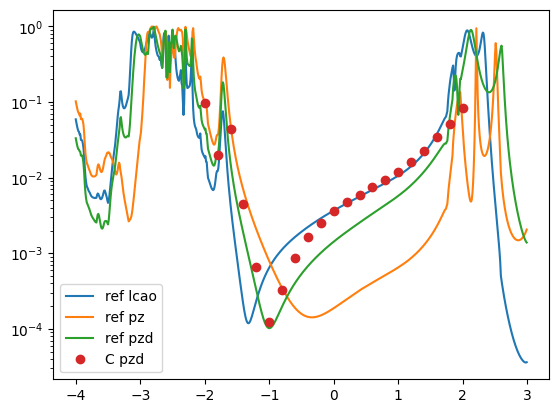

In [36]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="C pzd")
plt.yscale("log")
plt.legend()